# 7. Pipelines and transformers

This notebook showcases the current version of data processing pipelines in CapyMOA. 

* Includes examples of how preprocessing can be accomplished via pipelines and transformers.
* Transformers transform an instance, e.g., using standardisation, normalisation, etc.
* Pipelines bundle transformers, drift detectors, and learners (classifiers, regressors, clustering algorithms etc.)
* Some pipelines act as classifiers or regressors.

---

<span style="color:red"><b>Please note that this feature is still under development; some functionality might not yet be available or change in future releases.</b></span>

*More information about CapyMOA can be found at* https://www.capymoa.org.

**last update on 28/11/2025**

## 7.1 Introduction

We've redesigned the pipeline API to be more flexible and modular compared to the initial version.

- The new API is now generic, meaning it can handle all types of data stream algorithms (e.g., classifiers, regressors, data transformations, change detectors, clustering etc). The only requirement is that there exists a `PipelineElement` class compatible with the algorithm. This class represents a single step within the pipeline and provides a unified interface for the overall pipeline object (which is of type `BasePipeline`).
- A pipeline can also function as a `PipelineElement`. This allows for the creation of smaller pipelines that can be combined into a larger pipeline. For instance, you could create separate data cleaning, transformation, and prediction pipelines and then integrate them into one comprehensive pipeline.
- Besides the vanilla `BasePipeline`, we currently support `ClassifierPipeline` and `RegressorPipeline`. These classes act as CapyMOA `Classifiers` and `Regressors`, meaning they support `predict` and `train`.
- Adding drift detectors to a pipeline and specifying their behavior and position within the pipeline is flexible and intuitive.

This notebook explores these various options with examples.

### 7.1.1 PipelineElements and their structure

We currently support four types of pipeline elements: `ClassifierPipelineElement`, `RegressorPipelineElement`, `TransformerPipelineElement`, and `DriftDetectorPipelineElement`. They all implement the `PipelineElement` protocol, which provides two functions:

1. `pass_forward(instance) -> Instance`
    - Passes the instance through the pipeline.
    - The specific action taken depends on the type of pipeline element.
    - For example, a `TransformerPipelineElement` applies a transformation to the instance.
2. `pass_forward_predict(instance, prediction) -> Tuple[Instance, Any]`
    - Similar to `pass_forward` but can also pass along a prediction.
    - For example, a classifier could predict the instance's label and then pass the tuple `(instance, prediction)` to the next element in the pipeline.

This protocol offers great flexibility. For instance, one could develop a `ClusteringPipelineElement` that performs clustering and then passes the instance and clustering result to the next element in the pipeline.

Let's now look at the currently supported pipeline elements.

#### 7.1.2 TransformerPipelineElement

This element is initialized with a CapyMOA `Transformer`.
- `pass_forward` transforms and returns the provided instance.
- `pass_forward_predict` transforms the provided instance and returns the transformed instance and the input prediction.

#### 7.1.3 ClassifierPipelineElement and RegressorPipelineElement

These elements are initialised with a CapyMOA `Classifier` or `Regressor`.
- `pass_forward` trains the learner on the provided instance.
- `pass_forward_predict` predicts the label/value of the instance and returns `(instance, prediction)`.

#### 7.1.4 DriftDetectorPipelineElement

This element is initialised with a CapyMOA `BaseDriftDetector` and a callable `prepare_drift_detector_input_func` that takes an instance as input and returns the input for the change detector.
- `pass_forward` does nothing.
- `pass_forward_predict` updates the change detector. Internally, the drift detector calls `prepare_drift_detector_input_func` and passes the output to the change detector.

The `prepare_drift_detector_input_func` offers flexibility: it can be used to select a subset of features for the drift detector to monitor (e.g., for unsupervised drift detection), to compute the prediction error (e.g., for regression), or to check if the prediction matches the label (for classification).

#### 7.1.5 BasePipeline (and inheritors)
Pipelines themselves are pipeline elements, allowing you to combine them into larger pipelines.
- `pass_forward` calls `pass_forward` on all its elements.
- `pass_forward_predict` calls `pass_forward_predict` on all its elements.

## 7.2 Running online bagging without any preprocessing

First, let us have a look at a simple test-then-train classification example without pipelines. 
- We loop over the instances of the data stream.
- Make a prediction.
- Update the evaluator with the prediction and label.
- And then train the classifier on the instance.

In [1]:
# This cell is hidden on capymoa.org. See docs/contributing/docs.rst
from util.nbmock import mock_datasets, is_nb_fast

if is_nb_fast():
    mock_datasets()

In [2]:
## Test-then-train loop
from capymoa.datasets import Electricity
from capymoa.classifier import OnlineBagging
from capymoa.evaluation import ClassificationEvaluator

## Opening a file as a stream
elec_stream = Electricity()

# Creating a learner
ob_learner = OnlineBagging(schema=elec_stream.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()

    prediction = ob_learner.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    ob_learner.train(instance)

ob_evaluator.accuracy()

82.06656073446328

## 7.3 Transforming instances using pipelines

If we want to perform some preprocessing, such as normalisation or feature transformation, or a combination of both, we can chain multiple `Transformer`s within a pipeline. The most basic pipeline class `BasePipeline` already supports this.

Creating a basic pipeline consists of the following steps:
1. Create a stream instance.
2. Initialise the transformers.
3. Create the `BasePipeline`.
4. Add the transformers to the pipeline.
5. Call `pass_forward` to apply the transformations.

In [3]:
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import BasePipeline
from moa.streams.filters import AddNoiseFilter, NormalisationFilter

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)
add_noise_transformer = MOATransformer(
    schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter()
)

# Creating and populating the pipeline
pipeline = BasePipeline()

# Add the transformers to the pipeline. We can change the calls to add_transformer, as they return self
pipeline = pipeline.add_transformer(normalisation_transformer).add_transformer(
    add_noise_transformer
)

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    transformed_instance = pipeline.pass_forward(instance)
    prediction = ob_learner.predict(transformed_instance)
    ob_evaluator.update(instance.y_index, prediction)
    ob_learner.train(transformed_instance)

ob_evaluator.accuracy()

77.5048552259887

## 7.4 Online Bagging using pipelines and transformers

Similar as classifiers, a `ClassifierPipeline` supports `train` and `test`. Hence, we can use it in the same way as we would use other capymoa classifiers. 

- When calling `train`, the pipeline object internally calls `pass_forward` on all elements.
- When calling test, the pipeline object internally calls `pass_forward_predict` on all elements and then returns the resulting prediction.

Creating a pipeline consists of the following steps:

1. Create a stream instance
2. Initialize the transformers
3. Initialize the learner
4. Create the pipeline. Here, we use a `ClassifierPipeline`
5. Add the transformers and the classifier
6. Use the pipeline the same way as any other learner.

In [4]:
from capymoa.stream.preprocessing import MOATransformer
from capymoa.stream.preprocessing import ClassifierPipeline
from moa.streams.filters import AddNoiseFilter, NormalisationFilter

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)
add_noise_transformer = MOATransformer(
    schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter()
)

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating and populating the pipeline
pipeline = (
    ClassifierPipeline()
    .add_transformer(normalisation_transformer)
    .add_transformer(add_noise_transformer)
    .add_classifier(ob_learner)
)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)

ob_evaluator.accuracy()

77.5048552259887

We can also get a textual representation of the pipeline:

In [5]:
str(pipeline)

'PE(Transformer(NormalisationFilter)) | PE(Transformer(AddNoiseFilter)) | PE(OnlineBagging) | '

### 7.4.1 Alternative syntax

* An alternative syntax to define the pipeline is shown below.
* Since the pipeline behaves like a learner, it can be used with high-level evaluation functions like `prequential_evaluation`.

AdaptiveRandomForest: 88.55049435028248
PE(Transformer(NormalisationFilter)) | PE(AdaptiveRandomForest) | : 88.04069562146893


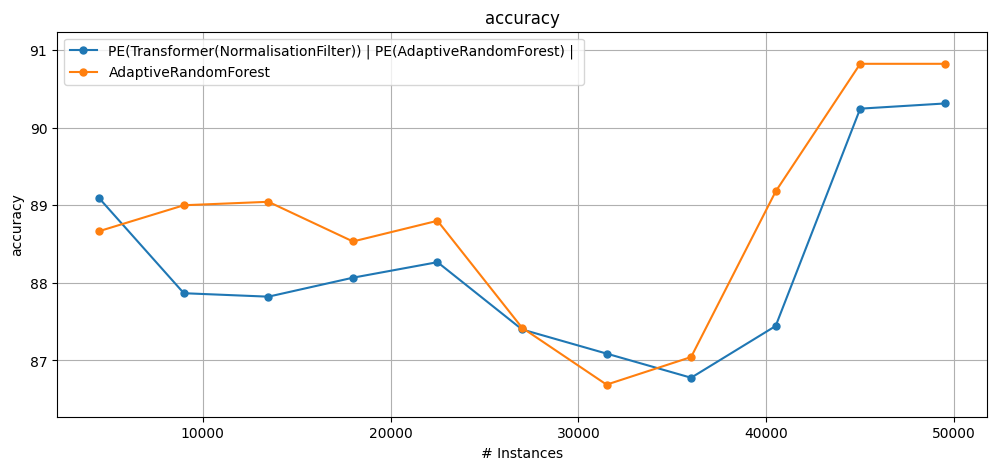

In [6]:
from capymoa.evaluation import prequential_evaluation
from capymoa.classifier import AdaptiveRandomForestClassifier
from capymoa.evaluation.visualization import plot_windowed_results
from capymoa.stream.preprocessing import (
    TransformerPipelineElement,
    ClassifierPipelineElement,
)

elec_stream = Electricity()

# Creating a transformer
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)

# Creating an ARF classifier as a baseline
arf = AdaptiveRandomForestClassifier(
    schema=normalisation_transformer.get_schema(), ensemble_size=5
)

# Alternative syntax.
## first create the pipeline elements
normalisation_transformer_pe = TransformerPipelineElement(normalisation_transformer)
classifier_pe = ClassifierPipelineElement(
    AdaptiveRandomForestClassifier(
        schema=add_noise_transformer.get_schema(), ensemble_size=5
    )
)
## then pass them as a list to the pipeline initialiser
pipeline_arf = ClassifierPipeline([normalisation_transformer_pe, classifier_pe])

results_arf_pipeline = prequential_evaluation(
    stream=elec_stream, learner=pipeline_arf, window_size=4500
)
results_arf_baseline = prequential_evaluation(
    stream=elec_stream, learner=arf, window_size=4500
)

print(f"{arf}: {results_arf_baseline['cumulative'].accuracy()}")
print(f"{pipeline_arf}: {results_arf_pipeline['cumulative'].accuracy()}")
plot_windowed_results(
    results_arf_pipeline, results_arf_baseline, metric="accuracy", figure_path=None
)

## 7.5 RegressorPipeline

* The regression version of the pipeline is quite similar to the classification one.

In [7]:
from capymoa.regressor import AdaptiveRandomForestRegressor
from capymoa.stream.preprocessing import RegressorPipeline
from capymoa.evaluation import RegressionEvaluator
from capymoa.datasets import Fried

fried_stream = Fried()

# Creating a transformer
normalisation_transformer = MOATransformer(
    schema=fried_stream.get_schema(), moa_filter=NormalisationFilter()
)

arfreg = AdaptiveRandomForestRegressor(
    schema=normalisation_transformer.get_schema(), ensemble_size=5
)

# Creating and populating the pipeline
pipeline_arfreg = RegressorPipeline()
pipeline_arfreg.add_transformer(normalisation_transformer)
pipeline_arfreg.add_regressor(arfreg)

# Creating the evaluator
arfreg_evaluator = RegressionEvaluator(schema=fried_stream.get_schema())

while fried_stream.has_more_instances():
    instance = fried_stream.next_instance()
    prediction = pipeline_arfreg.predict(instance)
    arfreg_evaluator.update(instance.y_value, prediction)
    pipeline_arfreg.train(instance)

print(arfreg_evaluator.rmse())

3.7340856941530185


## 7.6 Adding a drift detector to the pipeline

Let us now add a change detector to the pipeline from section 2.

Adding a drift detector to a pipeline requires the following steps:
1. Create the drift detector.
2. Define a function that prepares the input for the drift detector based on an instance and a prediction (which can be `None`).
3. Create and populate the pipeline.
4. Run the pipeline.

### 7.6.1 Monitoring classifier accuracy

In [8]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)
add_noise_transformer = MOATransformer(
    schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter()
)

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating a drift detector
drift_detector = ADWIN()


# Define a function that prepares the input of the drift detector
def label_equals_prediction(
    instance: LabeledInstance, prediction: LabelIndex
) -> LabelIndex:
    label = instance.y_index
    return int(label == prediction)


# Creating and populating the pipeline
pipeline = (
    ClassifierPipeline()
    .add_transformer(normalisation_transformer)
    .add_transformer(add_noise_transformer)
    .add_classifier(ob_learner)
    .add_drift_detector(
        drift_detector, get_drift_detector_input_func=label_equals_prediction
    )
)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

ob_evaluator.accuracy()

Detected change at index 3487
Detected change at index 8735
Detected change at index 10399
Detected change at index 10559
Detected change at index 10751
Detected change at index 11039
Detected change at index 13343
Detected change at index 13855
Detected change at index 17247
Detected change at index 17343
Detected change at index 18623
Detected change at index 18719
Detected change at index 18975
Detected change at index 19295
Detected change at index 21215
Detected change at index 21375
Detected change at index 23359
Detected change at index 23391
Detected change at index 24127
Detected change at index 25023
Detected change at index 25119
Detected change at index 35327
Detected change at index 35487
Detected change at index 39999
Detected change at index 40127
Detected change at index 40991
Detected change at index 41439


77.5048552259887

### 7.6.2 Monitoring drift in the first input feature

We now show how one can easily monitor an input feature by adapting `get_drift_detector_input_func` and the position of the drift detector in the pipeline. 

For the sake of illustration, this example is very simple. However, one can easily think of more complex use cases of `get_drift_detector_input_func`. One can provide any object that implements `__call__(instance, prediction)`. For example, one could provide a class that monitors the correlation between a set of input features.

In [9]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)
add_noise_transformer = MOATransformer(
    schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter()
)

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating a drift detector
drift_detector = ADWIN()


# Define a function that prepares the input of the drift detector
def first_feature_is_gt_zero(
    instance: LabeledInstance, prediction: LabelIndex
) -> LabelIndex:
    feature_val = instance.x[0]
    return int(feature_val > 0.0)


# Creating and populating the pipeline
pipeline = (
    ClassifierPipeline()
    .add_transformer(normalisation_transformer)
    # here, we add the drift detector after the normalization step
    .add_drift_detector(
        drift_detector, get_drift_detector_input_func=first_feature_is_gt_zero
    )
    .add_transformer(add_noise_transformer)
    .add_classifier(ob_learner)
)

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

ob_evaluator.accuracy()

Detected change at index 95
Detected change at index 159


77.5048552259887

## 7.7 Pipelines within pipelines

The following example is based on section 4.1 and shows how one can plug together multiple pipelines.

In [10]:
from capymoa.drift.detectors import ADWIN
from capymoa.instance import LabeledInstance
from capymoa.type_alias import LabelIndex

elec_stream = Electricity()

# Creating the transformers
normalisation_transformer = MOATransformer(
    schema=elec_stream.get_schema(), moa_filter=NormalisationFilter()
)
add_noise_transformer = MOATransformer(
    schema=normalisation_transformer.get_schema(), moa_filter=AddNoiseFilter()
)

# Creating a learner
ob_learner = OnlineBagging(schema=add_noise_transformer.get_schema(), ensemble_size=5)

# Creating a drift detector
drift_detector = ADWIN()


# Define a function that prepares the input of the drift detector
def label_equals_prediction(
    instance: LabeledInstance, prediction: LabelIndex
) -> LabelIndex:
    label = instance.y_index
    return int(label == prediction)


# Creating and populating the transformation pipeline
trafo_pipeline = (
    BasePipeline()
    .add_transformer(normalisation_transformer)
    .add_transformer(add_noise_transformer)
)

# Creating and populating the prediction pipeline
prediction_pipeline = ClassifierPipeline().add_classifier(ob_learner)

# Creating and populating the drift detection pipeline
drift_pipeline = BasePipeline().add_drift_detector(
    drift_detector, get_drift_detector_input_func=label_equals_prediction
)

# Since pipelines themselves are pipeline elements, we can pass them to the initializer of an overall pipeline object
pipeline = ClassifierPipeline([trafo_pipeline, prediction_pipeline, drift_pipeline])

# An alternative syntax would be
# pipeline = (ClassifierPipeline()
#             .add_pipeline_element(trafo_pipeline)
#             .add_pipeline_element(prediction_pipeline)
#             .add_pipeline_element(drift_pipeline))

# Creating the evaluator
ob_evaluator = ClassificationEvaluator(schema=elec_stream.get_schema())

i = 0
while elec_stream.has_more_instances():
    instance = elec_stream.next_instance()
    prediction = pipeline.predict(instance)
    ob_evaluator.update(instance.y_index, prediction)
    pipeline.train(instance)
    if drift_detector.detected_change():
        print(f"Detected change at index {i}")
    i += 1

ob_evaluator.accuracy()

Detected change at index 3487
Detected change at index 8735
Detected change at index 10399
Detected change at index 10559
Detected change at index 10751
Detected change at index 11039
Detected change at index 13343
Detected change at index 13855
Detected change at index 17247
Detected change at index 17343
Detected change at index 18623
Detected change at index 18719
Detected change at index 18975
Detected change at index 19295
Detected change at index 21215
Detected change at index 21375
Detected change at index 23359
Detected change at index 23391
Detected change at index 24127
Detected change at index 25023
Detected change at index 25119
Detected change at index 35327
Detected change at index 35487
Detected change at index 39999
Detected change at index 40127
Detected change at index 40991
Detected change at index 41439


77.5048552259887